Setting and importing necessary library

In [4]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.4.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Load Data

In [22]:
import torch
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
import torch_geometric.transforms as T
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [6]:
# Load datasets
users = pd.read_csv('/kaggle/input/fun-with-movie-lens-1m-subset/ml-1m/users.dat', sep='::', header=None, engine='python',
                    names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])
movies = pd.read_csv('/kaggle/input/fun-with-movie-lens-1m-subset/ml-1m/movies.dat', sep='::', header=None, engine='python',
                     names=['movie_id', 'title', 'genres'], encoding='latin1')
ratings = pd.read_csv('/kaggle/input/fun-with-movie-lens-1m-subset/ml-1m/ratings.dat', sep='::', header=None, engine='python',
                      names=['user_id', 'movie_id', 'rating', 'timestamp'])

In [7]:
# Encode gender as numerical
users['gender'] = users['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [8]:
# Encode genres using one-hot encoding
all_genres = set(g for genres in movies['genres'].str.split('|') for g in genres)
for genre in all_genres:
    movies[genre] = movies['genres'].apply(lambda x: int(genre in x.split('|')))
movies = movies.drop('genres', axis=1)

In [9]:
unique_user_id = users['user_id'].unique()

unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})

# Mapping of movie IDs to consecutive values
unique_movie_id = movies['movie_id'].unique()

unique_movie_id = pd.DataFrame(data={
    'movieId': unique_movie_id,
    'mappedID': pd.RangeIndex(len(unique_movie_id)),
})
unique_movie_id.head()

movieId  mappedID
0        1         0
1        2         1
2        3         2
3        4         3
4        5         4

In [10]:


# Số lượng fold
k = 10

In [11]:
# Khởi tạo K-Fold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [12]:
# Duyệt qua từng fold
fold_data = []
for fold, (train_idx, val_idx) in enumerate(kf.split(ratings)):
    train_data = ratings.iloc[train_idx]
    val_data = ratings.iloc[val_idx]
    
    print(f"Fold {fold + 1}")
    print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}")
    fold_data.append((train_data, val_data))

Fold 1
Train size: 900188, Validation size: 100021
Fold 2
Train size: 900188, Validation size: 100021
Fold 3
Train size: 900188, Validation size: 100021
Fold 4
Train size: 900188, Validation size: 100021
Fold 5
Train size: 900188, Validation size: 100021
Fold 6
Train size: 900188, Validation size: 100021
Fold 7
Train size: 900188, Validation size: 100021
Fold 8
Train size: 900188, Validation size: 100021
Fold 9
Train size: 900188, Validation size: 100021
Fold 10
Train size: 900189, Validation size: 100020


In [13]:
from torch_geometric.data import Data

# Tạo danh sách chứa các đồ thị cho từng fold
graph_folds = []

for train_data, val_data in fold_data:
    # Chuẩn bị edge_index và edge_attr cho train
    train_merged_user = train_data.merge(unique_user_id, left_on='user_id', right_on='userId', how='left')
    train_merged_movie = train_data.merge(unique_movie_id, left_on='movie_id', right_on='movieId', how='left')
    train_edge_index = torch.stack([
        torch.tensor(train_merged_user['mappedID'].values),
        torch.tensor(train_merged_movie['mappedID'].values)
    ], dim=0)
    train_edge_attr = torch.tensor(train_data['rating'].values, dtype=torch.float)
    
    # Tương tự cho validation
    val_merged_user = val_data.merge(unique_user_id, left_on='user_id', right_on='userId', how='left')
    val_merged_movie = val_data.merge(unique_movie_id, left_on='movie_id', right_on='movieId', how='left')
    val_edge_index = torch.stack([
        torch.tensor(val_merged_user['mappedID'].values),
        torch.tensor(val_merged_movie['mappedID'].values)
    ], dim=0)
    val_edge_attr = torch.tensor(val_data['rating'].values, dtype=torch.float)
    
    # Tạo đồ thị train và val
    train_graph = HeteroData()
    train_graph['user', 'rates', 'movie'].edge_index = train_edge_index
    train_graph['user', 'rates', 'movie'].edge_attr = train_edge_attr
    train_graph = T.ToUndirected()(train_graph)

    
    val_graph = HeteroData()
    val_graph['user', 'rates', 'movie'].edge_index = val_edge_index
    val_graph['user', 'rates', 'movie'].edge_attr = val_edge_attr
    val_graph = T.ToUndirected()(val_graph)
    
    graph_folds.append((train_graph, val_graph))

# Bây giờ, graph_folds chứa K bộ train/val đồ thị


In [14]:
# Tập hợp tất cả các user_id và movie_id
all_users = set(unique_user_id)
all_movies = set(unique_movie_id)

for fold_idx, (train_graph, val_graph) in enumerate(graph_folds):
    train_graph["user"].node_id = torch.arange(len(unique_user_id))
    train_graph["movie"].node_id = torch.arange(len(movies))

    user_features = torch.tensor(users[['gender', 'age', 'occupation']].values, dtype=torch.float)
    train_graph['user'].x = user_features

    # Chuẩn bị dữ liệu phim (movie nodes)
    movie_features = torch.tensor(movies.drop(['title', 'movie_id'], axis=1).values, dtype=torch.float)
    train_graph['movie'].x = movie_features

    val_graph["user"].node_id = torch.arange(len(unique_user_id))
    val_graph["movie"].node_id = torch.arange(len(movies))

    user_features = torch.tensor(users[['gender', 'age', 'occupation']].values, dtype=torch.float)
    val_graph['user'].x = user_features

    # Chuẩn bị dữ liệu phim (movie nodes)
    movie_features = torch.tensor(movies.drop(['title', 'movie_id'], axis=1).values, dtype=torch.float)
    val_graph['movie'].x = movie_features
    # Cập nhật đồ thị train
    graph_folds[fold_idx] = (train_graph, val_graph)


In [15]:
# Áp dụng transform RandomLinkSplit:
import torch_geometric.transforms as T
transform = T.RandomLinkSplit(
    num_val=0.0,
    num_test=0.0,
    disjoint_train_ratio=0.3,
    add_negative_train_samples=False,
    edge_types=("user", "rates", "movie"),
    rev_edge_types=("movie", "rev_rates", "user"),
)

In [16]:
train_loader_list = []
val_loader_list = []
test_loader_list = []

In [17]:
for fold in graph_folds:
    train_data, _, _ = transform(fold[0])
    val_data, _, _ = transform(fold[1])

    # Define seed edges:
    edge_label_index = train_data["user", "rates", "movie"].edge_label_index
    edge_label = train_data["user", "rates", "movie"].edge_label
    
    train_loader = LinkNeighborLoader(
        data=train_data,  # TODO
        num_neighbors=[20, 10],  # TODO
        neg_sampling_ratio=2.0,  # TODO
        edge_label_index=(("user", "rates", "movie"), edge_label_index),
        edge_label=edge_label,
        batch_size=12384,
        shuffle=True,
    )

    # Define seed edges:
    edge_label_index = val_data["user", "rates", "movie"].edge_label_index
    edge_label = val_data["user", "rates", "movie"].edge_label
    
    val_loader = LinkNeighborLoader(
        data=val_data,  # TODO
        num_neighbors=[20, 10],  # TODO
        neg_sampling_ratio=2.0,  # TODO
        edge_label_index=(("user", "rates", "movie"), edge_label_index),
        edge_label=edge_label,
        batch_size=1024,
        shuffle=True,
    )

    train_loader_list.append(train_loader)
    val_loader_list.append(val_loader)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [18]:
torch.save(train_loader_list, "train_loader.pt")
torch.save(val_loader_list, "val_loader.pt")

In [19]:
from torch_geometric.nn import GATConv, to_hetero
import torch.nn.functional as F
from torch_geometric.data import HeteroData

from torch import Tensor
#sageconv

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GATConv(hidden_channels, hidden_channels,heads = 8, add_self_loops=False)
        self.conv2 = GATConv(hidden_channels * 8, hidden_channels,heads = 1, add_self_loops=False)
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.movie_lin = torch.nn.Linear(18, hidden_channels)
        self.user_emb = torch.nn.Embedding(6040, hidden_channels)
        self.movie_emb = torch.nn.Embedding(6040, hidden_channels)
        self.gnn = GNN(hidden_channels)
        self.gnn = to_hetero(self.gnn, metadata=val_data.metadata())
        self.classifier = Classifier()
    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        }

        x_dict = self.gnn(x_dict, data.edge_index_dict)

        if "edge_label_index" in data["user", "rates", "movie"]:
            edge_label_index = data["user", "rates", "movie"].edge_label_index
        else:
            edge_label_index = data["user", "rates", "movie"].edge_index

        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            edge_label_index,
        )

        return pred

model = Model(hidden_channels=64)

In [20]:
foldloss1 = []
foldvalroc1=[]
predict1 = []
truth1 = []

In [24]:
import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

# from torch_geometric.nn import DataParallel
# from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
print("Training model with GATConv")
model = model.to(device)
# model = DataParallel(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=5)
n_epochs=1
model.train(True)
for idx, (train_loaderloader, val_loader) in enumerate(zip(train_loader_list,val_loader_list)):
    print(f"FOLD: {idx + 1}")
    gatconvloss=[]
    gatvalroc=[]
    for layer in model.children():
       if hasattr(layer, 'reset_parameters'):
        print(f'Reset trainable parameters of layer = {layer}')
        layer.reset_parameters()
    for epoch in range(30):
        model.train(True)
        total_loss = total_examples = 0
        print(f"Epoch: {epoch+1}",sep='')
    
        for sampled_data in tqdm.tqdm(train_loader):
            optimizer.zero_grad()
            sampled_data.to(device)
            pred = model(sampled_data)
            ground_truth = sampled_data["user", "rates", "movie"].edge_label
            loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
            loss.backward()
            optimizer.step()
            # scheduler.step(loss)
            optimizer.zero_grad()
            total_loss += float(loss) * pred.numel()
            total_examples += pred.numel()
        model.eval()
        preds = []
        ground_truths = []
        for sampled_data in tqdm.tqdm(val_loader):
            with torch.no_grad():
                sampled_data.to(device)
                preds.append(model(sampled_data))
                ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)
        pred = torch.cat(preds, dim=0).cpu().numpy()
        ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

        auc = roc_auc_score(ground_truth, pred)
        print(f"Loss: {total_loss / total_examples:.4f}, AUC on val: {auc}")
        loss = total_loss / total_examples
        gatconvloss.append(round(loss, 4))
        gatvalroc.append(auc)
    foldloss1.append(gatconvloss)
    foldvalroc1.append(gatvalroc)
    predict1.append(pred)
    truth1.append(ground_truth)

Device: 'cuda'
Training model with GATConv
FOLD: 1
Reset trainable parameters of layer = Linear(in_features=18, out_features=64, bias=True)
Reset trainable parameters of layer = Embedding(6040, 64)
Reset trainable parameters of layer = Embedding(6040, 64)
Epoch: 1


100%|██████████| 30/30 [00:02<00:00, 12.77it/s]


Loss: 0.8678, AUC on val: 0.6779201353845963
Epoch: 2


100%|██████████| 30/30 [00:02<00:00, 12.03it/s]


Loss: 0.6261, AUC on val: 0.6729238863062998
Epoch: 3


100%|██████████| 30/30 [00:02<00:00, 12.67it/s]


Loss: 0.6117, AUC on val: 0.6862743539185695
Epoch: 4


100%|██████████| 30/30 [00:02<00:00, 12.73it/s]


Loss: 0.5960, AUC on val: 0.7000586452062384
Epoch: 5


100%|██████████| 30/30 [00:02<00:00, 12.54it/s]


Loss: 0.5790, AUC on val: 0.7150595881179248
Epoch: 6


100%|██████████| 30/30 [00:02<00:00, 12.56it/s]


Loss: 0.5625, AUC on val: 0.7300086270710487
Epoch: 7


100%|██████████| 30/30 [00:02<00:00, 12.42it/s]


Loss: 0.5479, AUC on val: 0.742317029051254
Epoch: 8


100%|██████████| 30/30 [00:02<00:00, 12.48it/s]


Loss: 0.5364, AUC on val: 0.7532445442747305
Epoch: 9


100%|██████████| 30/30 [00:02<00:00, 12.05it/s]


Loss: 0.5246, AUC on val: 0.765835225831814
Epoch: 10


100%|██████████| 30/30 [00:02<00:00, 12.64it/s]


Loss: 0.5179, AUC on val: 0.7706698578967136
Epoch: 11


100%|██████████| 30/30 [00:02<00:00, 12.69it/s]


Loss: 0.5104, AUC on val: 0.7713290702964963
Epoch: 12


100%|██████████| 30/30 [00:02<00:00, 12.58it/s]


Loss: 0.5045, AUC on val: 0.7757666189884065
Epoch: 13


100%|██████████| 30/30 [00:02<00:00, 12.63it/s]


Loss: 0.4996, AUC on val: 0.7797736343553126
Epoch: 14


100%|██████████| 30/30 [00:02<00:00, 12.70it/s]


Loss: 0.4956, AUC on val: 0.7811227579852289
Epoch: 15


100%|██████████| 30/30 [00:02<00:00, 12.37it/s]


Loss: 0.4949, AUC on val: 0.7843711673804235
Epoch: 16


100%|██████████| 30/30 [00:02<00:00, 12.64it/s]


Loss: 0.4922, AUC on val: 0.7888696536393136
Epoch: 17


100%|██████████| 30/30 [00:02<00:00, 12.45it/s]


Loss: 0.4894, AUC on val: 0.7908263567131493
Epoch: 18


100%|██████████| 30/30 [00:02<00:00, 12.63it/s]


Loss: 0.4865, AUC on val: 0.7884036039667137
Epoch: 19


100%|██████████| 30/30 [00:02<00:00, 12.37it/s]


Loss: 0.4848, AUC on val: 0.7886597828737926
Epoch: 20


100%|██████████| 30/30 [00:02<00:00, 12.57it/s]


Loss: 0.4844, AUC on val: 0.7925282594950716
Epoch: 21


100%|██████████| 30/30 [00:02<00:00, 12.55it/s]


Loss: 0.4800, AUC on val: 0.7958615377171183
Epoch: 22


100%|██████████| 30/30 [00:02<00:00, 11.90it/s]


Loss: 0.4799, AUC on val: 0.7970805247957495
Epoch: 23


100%|██████████| 30/30 [00:02<00:00, 12.35it/s]


Loss: 0.4779, AUC on val: 0.7979619899522062
Epoch: 24


100%|██████████| 30/30 [00:02<00:00, 12.58it/s]


Loss: 0.4759, AUC on val: 0.797145780635248
Epoch: 25


100%|██████████| 30/30 [00:02<00:00, 12.43it/s]


Loss: 0.4749, AUC on val: 0.7954536333951633
Epoch: 26


100%|██████████| 30/30 [00:02<00:00, 12.02it/s]


Loss: 0.4752, AUC on val: 0.7961796115859588
Epoch: 27


100%|██████████| 30/30 [00:02<00:00, 12.61it/s]


Loss: 0.4711, AUC on val: 0.7980605899527063
Epoch: 28


100%|██████████| 30/30 [00:02<00:00, 12.47it/s]


Loss: 0.4711, AUC on val: 0.798674987502444
Epoch: 29


100%|██████████| 30/30 [00:02<00:00, 12.56it/s]


Loss: 0.4710, AUC on val: 0.7997862076921414
Epoch: 30


100%|██████████| 30/30 [00:02<00:00, 12.42it/s]


Loss: 0.4706, AUC on val: 0.800878591528245
FOLD: 2
Reset trainable parameters of layer = Linear(in_features=18, out_features=64, bias=True)
Reset trainable parameters of layer = Embedding(6040, 64)
Reset trainable parameters of layer = Embedding(6040, 64)
Epoch: 1


100%|██████████| 30/30 [00:02<00:00, 12.38it/s]


Loss: 0.8525, AUC on val: 0.34193159757259595
Epoch: 2


100%|██████████| 30/30 [00:02<00:00, 12.53it/s]


Loss: 0.6433, AUC on val: 0.4681133251120888
Epoch: 3


100%|██████████| 30/30 [00:02<00:00, 12.59it/s]


Loss: 0.6321, AUC on val: 0.6067657885806028
Epoch: 4


100%|██████████| 30/30 [00:02<00:00, 12.55it/s]


Loss: 0.6215, AUC on val: 0.6696851366579313
Epoch: 5


100%|██████████| 30/30 [00:02<00:00, 12.44it/s]


Loss: 0.6017, AUC on val: 0.694518266856971
Epoch: 6


100%|██████████| 30/30 [00:02<00:00, 11.34it/s]


Loss: 0.5778, AUC on val: 0.7148168380054576
Epoch: 7


100%|██████████| 30/30 [00:02<00:00, 12.27it/s]


Loss: 0.5607, AUC on val: 0.7188917931381841
Epoch: 8


100%|██████████| 30/30 [00:02<00:00, 12.07it/s]


Loss: 0.5498, AUC on val: 0.7258911414522179
Epoch: 9


100%|██████████| 30/30 [00:02<00:00, 12.31it/s]


Loss: 0.5414, AUC on val: 0.7305950005537563
Epoch: 10


100%|██████████| 30/30 [00:02<00:00, 12.53it/s]


Loss: 0.5347, AUC on val: 0.7412076281337747
Epoch: 11


100%|██████████| 30/30 [00:02<00:00, 12.70it/s]


Loss: 0.5277, AUC on val: 0.7434814432390022
Epoch: 12


100%|██████████| 30/30 [00:02<00:00, 12.67it/s]


Loss: 0.5230, AUC on val: 0.7519615775127539
Epoch: 13


100%|██████████| 30/30 [00:02<00:00, 12.16it/s]


Loss: 0.5159, AUC on val: 0.7558723663741111
Epoch: 14


100%|██████████| 30/30 [00:02<00:00, 12.58it/s]


Loss: 0.5099, AUC on val: 0.7620648199783048
Epoch: 15


100%|██████████| 30/30 [00:02<00:00, 12.65it/s]


Loss: 0.5036, AUC on val: 0.7696854791875725
Epoch: 16


100%|██████████| 30/30 [00:02<00:00, 12.69it/s]


Loss: 0.5063, AUC on val: 0.7682263826067909
Epoch: 17


100%|██████████| 30/30 [00:02<00:00, 12.65it/s]


Loss: 0.4998, AUC on val: 0.7723690370459757
Epoch: 18


100%|██████████| 30/30 [00:02<00:00, 12.61it/s]


Loss: 0.4971, AUC on val: 0.7752745522236841
Epoch: 19


100%|██████████| 30/30 [00:02<00:00, 12.63it/s]


Loss: 0.4950, AUC on val: 0.7794538492265997
Epoch: 20


100%|██████████| 30/30 [00:02<00:00, 12.21it/s]


Loss: 0.4909, AUC on val: 0.77767253210248
Epoch: 21


100%|██████████| 30/30 [00:02<00:00, 12.27it/s]


Loss: 0.4886, AUC on val: 0.7799598809603319
Epoch: 22


100%|██████████| 30/30 [00:02<00:00, 12.41it/s]


Loss: 0.4870, AUC on val: 0.779788733870458
Epoch: 23


100%|██████████| 30/30 [00:02<00:00, 11.97it/s]


Loss: 0.4851, AUC on val: 0.7817000717588491
Epoch: 24


100%|██████████| 30/30 [00:02<00:00, 12.52it/s]


Loss: 0.4864, AUC on val: 0.7856493307861567
Epoch: 25


100%|██████████| 30/30 [00:02<00:00, 12.39it/s]


Loss: 0.4823, AUC on val: 0.7866449622159817
Epoch: 26


100%|██████████| 30/30 [00:02<00:00, 12.68it/s]


Loss: 0.4825, AUC on val: 0.7895723061613098
Epoch: 27


100%|██████████| 30/30 [00:02<00:00, 12.73it/s]


Loss: 0.4795, AUC on val: 0.7882857077965643
Epoch: 28


100%|██████████| 30/30 [00:02<00:00, 12.70it/s]


Loss: 0.4794, AUC on val: 0.7913892693033746
Epoch: 29


100%|██████████| 30/30 [00:02<00:00, 12.69it/s]


Loss: 0.4767, AUC on val: 0.7927051076376295
Epoch: 30


100%|██████████| 30/30 [00:02<00:00, 12.27it/s]


Loss: 0.4759, AUC on val: 0.793267855293835
FOLD: 3
Reset trainable parameters of layer = Linear(in_features=18, out_features=64, bias=True)
Reset trainable parameters of layer = Embedding(6040, 64)
Reset trainable parameters of layer = Embedding(6040, 64)
Epoch: 1


100%|██████████| 30/30 [00:02<00:00, 12.43it/s]


Loss: 0.8586, AUC on val: 0.468474042199714
Epoch: 2


100%|██████████| 30/30 [00:02<00:00, 12.49it/s]


Loss: 0.6384, AUC on val: 0.4473347312696585
Epoch: 3


100%|██████████| 30/30 [00:02<00:00, 12.61it/s]


Loss: 0.6302, AUC on val: 0.5268098585952786
Epoch: 4


100%|██████████| 30/30 [00:02<00:00, 12.59it/s]


Loss: 0.6238, AUC on val: 0.6163999037158508
Epoch: 5


100%|██████████| 30/30 [00:02<00:00, 12.40it/s]


Loss: 0.6112, AUC on val: 0.6689028937530497
Epoch: 6


100%|██████████| 30/30 [00:02<00:00, 12.55it/s]


Loss: 0.5858, AUC on val: 0.6885229796561072
Epoch: 7


100%|██████████| 30/30 [00:02<00:00, 12.51it/s]


Loss: 0.5677, AUC on val: 0.7052570845114676
Epoch: 8


100%|██████████| 30/30 [00:02<00:00, 12.55it/s]


Loss: 0.5532, AUC on val: 0.7193628016603794
Epoch: 9


100%|██████████| 30/30 [00:02<00:00, 12.72it/s]


Loss: 0.5426, AUC on val: 0.7308851733619149
Epoch: 10


100%|██████████| 30/30 [00:02<00:00, 12.74it/s]


Loss: 0.5329, AUC on val: 0.7390342581242688
Epoch: 11


100%|██████████| 30/30 [00:02<00:00, 12.69it/s]


Loss: 0.5236, AUC on val: 0.7476085566729884
Epoch: 12


100%|██████████| 30/30 [00:02<00:00, 12.67it/s]


Loss: 0.5146, AUC on val: 0.7478676094304122
Epoch: 13


100%|██████████| 30/30 [00:02<00:00, 12.72it/s]


Loss: 0.5092, AUC on val: 0.7561380972933365
Epoch: 14


100%|██████████| 30/30 [00:02<00:00, 12.69it/s]


Loss: 0.5026, AUC on val: 0.7592291127079746
Epoch: 15


100%|██████████| 30/30 [00:02<00:00, 12.53it/s]


Loss: 0.5000, AUC on val: 0.7630631842037912
Epoch: 16


100%|██████████| 30/30 [00:02<00:00, 12.69it/s]


Loss: 0.4948, AUC on val: 0.7699309221116962
Epoch: 17


100%|██████████| 30/30 [00:02<00:00, 12.48it/s]


Loss: 0.4913, AUC on val: 0.7727332382953523
Epoch: 18


100%|██████████| 30/30 [00:02<00:00, 12.51it/s]


Loss: 0.4893, AUC on val: 0.7732767572549166
Epoch: 19


100%|██████████| 30/30 [00:02<00:00, 12.48it/s]


Loss: 0.4869, AUC on val: 0.7774371798639006
Epoch: 20


100%|██████████| 30/30 [00:02<00:00, 12.61it/s]


Loss: 0.4841, AUC on val: 0.776283614947121
Epoch: 21


100%|██████████| 30/30 [00:02<00:00, 12.71it/s]


Loss: 0.4825, AUC on val: 0.7815888334808321
Epoch: 22


100%|██████████| 30/30 [00:02<00:00, 12.71it/s]


Loss: 0.4802, AUC on val: 0.7834992975521184
Epoch: 23


100%|██████████| 30/30 [00:02<00:00, 12.66it/s]


Loss: 0.4786, AUC on val: 0.7859686860868179
Epoch: 24


100%|██████████| 30/30 [00:02<00:00, 12.25it/s]


Loss: 0.4777, AUC on val: 0.7869273042678674
Epoch: 25


100%|██████████| 30/30 [00:02<00:00, 12.54it/s]


Loss: 0.4759, AUC on val: 0.7888450362650259
Epoch: 26


100%|██████████| 30/30 [00:02<00:00, 12.63it/s]


Loss: 0.4760, AUC on val: 0.7906029169313331
Epoch: 27


100%|██████████| 30/30 [00:02<00:00, 12.72it/s]


Loss: 0.4748, AUC on val: 0.7876658538185051
Epoch: 28


100%|██████████| 30/30 [00:02<00:00, 12.56it/s]


Loss: 0.4770, AUC on val: 0.7900394087460364
Epoch: 29


100%|██████████| 30/30 [00:02<00:00, 12.51it/s]


Loss: 0.4699, AUC on val: 0.7935285124094513
Epoch: 30


100%|██████████| 30/30 [00:02<00:00, 12.68it/s]


Loss: 0.4682, AUC on val: 0.7965183666259482
FOLD: 4
Reset trainable parameters of layer = Linear(in_features=18, out_features=64, bias=True)
Reset trainable parameters of layer = Embedding(6040, 64)
Reset trainable parameters of layer = Embedding(6040, 64)
Epoch: 1


100%|██████████| 30/30 [00:02<00:00, 12.22it/s]


Loss: 0.8358, AUC on val: 0.5867338757581195
Epoch: 2


100%|██████████| 30/30 [00:02<00:00, 12.53it/s]


Loss: 0.6351, AUC on val: 0.5822466652662491
Epoch: 3


100%|██████████| 30/30 [00:02<00:00, 12.48it/s]


Loss: 0.6285, AUC on val: 0.6298372185302102
Epoch: 4


100%|██████████| 30/30 [00:02<00:00, 12.58it/s]


Loss: 0.6212, AUC on val: 0.6653194114559744
Epoch: 5


100%|██████████| 30/30 [00:02<00:00, 12.53it/s]


Loss: 0.6083, AUC on val: 0.6874367036544035
Epoch: 6


100%|██████████| 30/30 [00:02<00:00, 12.45it/s]


Loss: 0.5894, AUC on val: 0.7042515886944587
Epoch: 7


100%|██████████| 30/30 [00:02<00:00, 12.56it/s]


Loss: 0.5714, AUC on val: 0.716530603264137
Epoch: 8


100%|██████████| 30/30 [00:02<00:00, 12.50it/s]


Loss: 0.5555, AUC on val: 0.7252409768218544
Epoch: 9


100%|██████████| 30/30 [00:02<00:00, 12.38it/s]


Loss: 0.5422, AUC on val: 0.7369169018181523
Epoch: 10


100%|██████████| 30/30 [00:02<00:00, 12.50it/s]


Loss: 0.5320, AUC on val: 0.7465536270203801
Epoch: 11


100%|██████████| 30/30 [00:02<00:00, 12.13it/s]


Loss: 0.5236, AUC on val: 0.7523667357110462
Epoch: 12


100%|██████████| 30/30 [00:02<00:00, 12.49it/s]


Loss: 0.5152, AUC on val: 0.7553204799285428
Epoch: 13


100%|██████████| 30/30 [00:02<00:00, 12.60it/s]


Loss: 0.5070, AUC on val: 0.761212270476652
Epoch: 14


100%|██████████| 30/30 [00:02<00:00, 12.52it/s]


Loss: 0.5025, AUC on val: 0.7630259590953234
Epoch: 15


100%|██████████| 30/30 [00:02<00:00, 12.44it/s]


Loss: 0.4972, AUC on val: 0.7675211958208238
Epoch: 16


100%|██████████| 30/30 [00:02<00:00, 12.30it/s]


Loss: 0.4937, AUC on val: 0.7699434104491951
Epoch: 17


100%|██████████| 30/30 [00:02<00:00, 12.24it/s]


Loss: 0.4912, AUC on val: 0.7699013475538135
Epoch: 18


100%|██████████| 30/30 [00:02<00:00, 11.79it/s]


Loss: 0.4880, AUC on val: 0.7757876425225965
Epoch: 19


100%|██████████| 30/30 [00:02<00:00, 12.43it/s]


Loss: 0.4851, AUC on val: 0.7779814071512166
Epoch: 20


100%|██████████| 30/30 [00:02<00:00, 12.47it/s]


Loss: 0.4844, AUC on val: 0.7788699664141912
Epoch: 21


100%|██████████| 30/30 [00:02<00:00, 12.79it/s]


Loss: 0.4810, AUC on val: 0.7841585579882401
Epoch: 22


100%|██████████| 30/30 [00:02<00:00, 12.79it/s]


Loss: 0.4814, AUC on val: 0.786237021519689
Epoch: 23


100%|██████████| 30/30 [00:02<00:00, 12.79it/s]


Loss: 0.4788, AUC on val: 0.7868472860005973
Epoch: 24


100%|██████████| 30/30 [00:02<00:00, 12.79it/s]


Loss: 0.4760, AUC on val: 0.7887406968938367
Epoch: 25


100%|██████████| 30/30 [00:02<00:00, 12.74it/s]


Loss: 0.4759, AUC on val: 0.7870046622104849
Epoch: 26


100%|██████████| 30/30 [00:02<00:00, 12.73it/s]


Loss: 0.4730, AUC on val: 0.7901274488042692
Epoch: 27


100%|██████████| 30/30 [00:02<00:00, 12.78it/s]


Loss: 0.4714, AUC on val: 0.7898472858806451
Epoch: 28


100%|██████████| 30/30 [00:02<00:00, 12.75it/s]


Loss: 0.4719, AUC on val: 0.7935730126631253
Epoch: 29


100%|██████████| 30/30 [00:02<00:00, 12.61it/s]


Loss: 0.4711, AUC on val: 0.7953917939667414
Epoch: 30


100%|██████████| 30/30 [00:02<00:00, 12.58it/s]


Loss: 0.4687, AUC on val: 0.7961618548004945
FOLD: 5
Reset trainable parameters of layer = Linear(in_features=18, out_features=64, bias=True)
Reset trainable parameters of layer = Embedding(6040, 64)
Reset trainable parameters of layer = Embedding(6040, 64)
Epoch: 1


100%|██████████| 30/30 [00:02<00:00, 12.44it/s]


Loss: 0.7694, AUC on val: 0.6187418132472509
Epoch: 2


100%|██████████| 30/30 [00:02<00:00, 12.69it/s]


Loss: 0.6281, AUC on val: 0.6472667526860333
Epoch: 3


100%|██████████| 30/30 [00:02<00:00, 12.03it/s]


Loss: 0.6109, AUC on val: 0.6828520857405093
Epoch: 4


100%|██████████| 30/30 [00:02<00:00, 12.16it/s]


Loss: 0.5857, AUC on val: 0.7112376934175697
Epoch: 5


100%|██████████| 30/30 [00:02<00:00, 12.36it/s]


Loss: 0.5648, AUC on val: 0.7253957054797577
Epoch: 6


100%|██████████| 30/30 [00:02<00:00, 12.68it/s]


Loss: 0.5486, AUC on val: 0.7349274135263818
Epoch: 7


100%|██████████| 30/30 [00:02<00:00, 12.67it/s]


Loss: 0.5375, AUC on val: 0.7396648208739464
Epoch: 8


100%|██████████| 30/30 [00:02<00:00, 12.59it/s]


Loss: 0.5272, AUC on val: 0.7436318061433815
Epoch: 9


100%|██████████| 30/30 [00:02<00:00, 12.70it/s]


Loss: 0.5211, AUC on val: 0.7478023766372499
Epoch: 10


100%|██████████| 30/30 [00:02<00:00, 12.60it/s]


Loss: 0.5133, AUC on val: 0.7545895698218219
Epoch: 11


100%|██████████| 30/30 [00:02<00:00, 12.53it/s]


Loss: 0.5079, AUC on val: 0.7607301708357923
Epoch: 12


100%|██████████| 30/30 [00:02<00:00, 12.44it/s]


Loss: 0.5020, AUC on val: 0.7636934173630958
Epoch: 13


100%|██████████| 30/30 [00:02<00:00, 12.48it/s]


Loss: 0.4969, AUC on val: 0.7651396354846651
Epoch: 14


100%|██████████| 30/30 [00:02<00:00, 12.54it/s]


Loss: 0.4934, AUC on val: 0.769028590580402
Epoch: 15


100%|██████████| 30/30 [00:02<00:00, 12.53it/s]


Loss: 0.4902, AUC on val: 0.7740680498728844
Epoch: 16


100%|██████████| 30/30 [00:02<00:00, 12.65it/s]


Loss: 0.4877, AUC on val: 0.7762327497396831
Epoch: 17


100%|██████████| 30/30 [00:02<00:00, 12.68it/s]


Loss: 0.4844, AUC on val: 0.7786079484540782
Epoch: 18


100%|██████████| 30/30 [00:02<00:00, 12.68it/s]


Loss: 0.4824, AUC on val: 0.781120495001624
Epoch: 19


100%|██████████| 30/30 [00:02<00:00, 12.60it/s]


Loss: 0.4795, AUC on val: 0.7821579699701376
Epoch: 20


100%|██████████| 30/30 [00:02<00:00, 12.57it/s]


Loss: 0.4763, AUC on val: 0.7825881717611021
Epoch: 21


100%|██████████| 30/30 [00:02<00:00, 12.61it/s]


Loss: 0.4762, AUC on val: 0.7829177715746592
Epoch: 22


100%|██████████| 30/30 [00:02<00:00, 12.36it/s]


Loss: 0.4747, AUC on val: 0.783936681192278
Epoch: 23


100%|██████████| 30/30 [00:02<00:00, 12.64it/s]


Loss: 0.4733, AUC on val: 0.7867997916668972
Epoch: 24


100%|██████████| 30/30 [00:02<00:00, 12.55it/s]


Loss: 0.4715, AUC on val: 0.7896593102450851
Epoch: 25


100%|██████████| 30/30 [00:02<00:00, 12.59it/s]


Loss: 0.4692, AUC on val: 0.7872058383986291
Epoch: 26


100%|██████████| 30/30 [00:02<00:00, 12.48it/s]


Loss: 0.4678, AUC on val: 0.7914548922182503
Epoch: 27


100%|██████████| 30/30 [00:02<00:00, 12.43it/s]


Loss: 0.4661, AUC on val: 0.7948314867231623
Epoch: 28


100%|██████████| 30/30 [00:02<00:00, 12.51it/s]


Loss: 0.4652, AUC on val: 0.7941708648872106
Epoch: 29


100%|██████████| 30/30 [00:02<00:00, 11.96it/s]


Loss: 0.4629, AUC on val: 0.7928875946355309
Epoch: 30


100%|██████████| 30/30 [00:02<00:00, 12.55it/s]


Loss: 0.4636, AUC on val: 0.795821607024326
FOLD: 6
Reset trainable parameters of layer = Linear(in_features=18, out_features=64, bias=True)
Reset trainable parameters of layer = Embedding(6040, 64)
Reset trainable parameters of layer = Embedding(6040, 64)
Epoch: 1


100%|██████████| 30/30 [00:02<00:00, 11.08it/s]


Loss: 0.7790, AUC on val: 0.5533253774382318
Epoch: 2


100%|██████████| 30/30 [00:02<00:00, 12.11it/s]


Loss: 0.6262, AUC on val: 0.6460136378709729
Epoch: 3


100%|██████████| 30/30 [00:02<00:00, 12.50it/s]


Loss: 0.6134, AUC on val: 0.6738342410168903
Epoch: 4


100%|██████████| 30/30 [00:02<00:00, 12.59it/s]


Loss: 0.5958, AUC on val: 0.6985366971019136
Epoch: 5


100%|██████████| 30/30 [00:02<00:00, 12.67it/s]


Loss: 0.5748, AUC on val: 0.7091108353569794
Epoch: 6


100%|██████████| 30/30 [00:02<00:00, 12.20it/s]


Loss: 0.5566, AUC on val: 0.7222110483588812
Epoch: 7


100%|██████████| 30/30 [00:02<00:00, 12.14it/s]


Loss: 0.5420, AUC on val: 0.7358679517179282
Epoch: 8


100%|██████████| 30/30 [00:02<00:00, 12.43it/s]


Loss: 0.5278, AUC on val: 0.7432211765227661
Epoch: 9


100%|██████████| 30/30 [00:02<00:00, 12.06it/s]


Loss: 0.5168, AUC on val: 0.7534244781273255
Epoch: 10


100%|██████████| 30/30 [00:02<00:00, 12.39it/s]


Loss: 0.5083, AUC on val: 0.7619435837554213
Epoch: 11


100%|██████████| 30/30 [00:02<00:00, 12.35it/s]


Loss: 0.5018, AUC on val: 0.7649281139906126
Epoch: 12


100%|██████████| 30/30 [00:02<00:00, 12.40it/s]


Loss: 0.4983, AUC on val: 0.7724477802677594
Epoch: 13


100%|██████████| 30/30 [00:02<00:00, 12.22it/s]


Loss: 0.4937, AUC on val: 0.7755877746999423
Epoch: 14


100%|██████████| 30/30 [00:02<00:00, 12.40it/s]


Loss: 0.4889, AUC on val: 0.7774957905839348
Epoch: 15


100%|██████████| 30/30 [00:02<00:00, 12.24it/s]


Loss: 0.4861, AUC on val: 0.7831264811380412
Epoch: 16


100%|██████████| 30/30 [00:02<00:00, 12.26it/s]


Loss: 0.4819, AUC on val: 0.7866228852143322
Epoch: 17


100%|██████████| 30/30 [00:02<00:00, 12.48it/s]


Loss: 0.4795, AUC on val: 0.7898174572577319
Epoch: 18


100%|██████████| 30/30 [00:02<00:00, 12.71it/s]


Loss: 0.4768, AUC on val: 0.7916290842011562
Epoch: 19


100%|██████████| 30/30 [00:02<00:00, 12.75it/s]


Loss: 0.4748, AUC on val: 0.7931139443643631
Epoch: 20


100%|██████████| 30/30 [00:02<00:00, 12.56it/s]


Loss: 0.4735, AUC on val: 0.7966077239350059
Epoch: 21


100%|██████████| 30/30 [00:02<00:00, 12.61it/s]


Loss: 0.4707, AUC on val: 0.7970150051728863
Epoch: 22


100%|██████████| 30/30 [00:02<00:00, 12.69it/s]


Loss: 0.4699, AUC on val: 0.8000149472982605
Epoch: 23


100%|██████████| 30/30 [00:02<00:00, 12.68it/s]


Loss: 0.4682, AUC on val: 0.8041983518246694
Epoch: 24


100%|██████████| 30/30 [00:02<00:00, 12.47it/s]


Loss: 0.4655, AUC on val: 0.8026976871505656
Epoch: 25


100%|██████████| 30/30 [00:02<00:00, 12.63it/s]


Loss: 0.4638, AUC on val: 0.8050667710888936
Epoch: 26


100%|██████████| 30/30 [00:02<00:00, 12.27it/s]


Loss: 0.4620, AUC on val: 0.8084156150284751
Epoch: 27


100%|██████████| 30/30 [00:02<00:00, 12.58it/s]


Loss: 0.4614, AUC on val: 0.8089254122003257
Epoch: 28


100%|██████████| 30/30 [00:02<00:00, 12.44it/s]


Loss: 0.4606, AUC on val: 0.8102811209736991
Epoch: 29


100%|██████████| 30/30 [00:02<00:00, 12.46it/s]


Loss: 0.4592, AUC on val: 0.8101341436593927
Epoch: 30


100%|██████████| 30/30 [00:02<00:00, 12.48it/s]


Loss: 0.4570, AUC on val: 0.8099104398165448
FOLD: 7
Reset trainable parameters of layer = Linear(in_features=18, out_features=64, bias=True)
Reset trainable parameters of layer = Embedding(6040, 64)
Reset trainable parameters of layer = Embedding(6040, 64)
Epoch: 1


100%|██████████| 30/30 [00:02<00:00, 12.55it/s]


Loss: 0.7639, AUC on val: 0.5919315781359269
Epoch: 2


100%|██████████| 30/30 [00:02<00:00, 12.52it/s]


Loss: 0.6276, AUC on val: 0.6519935967593302
Epoch: 3


100%|██████████| 30/30 [00:02<00:00, 12.09it/s]


Loss: 0.6117, AUC on val: 0.6897688956843038
Epoch: 4


100%|██████████| 30/30 [00:02<00:00, 12.47it/s]


Loss: 0.5908, AUC on val: 0.7103373316538452
Epoch: 5


100%|██████████| 30/30 [00:02<00:00, 12.57it/s]


Loss: 0.5718, AUC on val: 0.7209114090999037
Epoch: 6


100%|██████████| 30/30 [00:02<00:00, 12.61it/s]


Loss: 0.5566, AUC on val: 0.729040666793878
Epoch: 7


100%|██████████| 30/30 [00:02<00:00, 12.58it/s]


Loss: 0.5459, AUC on val: 0.7392624654433241
Epoch: 8


100%|██████████| 30/30 [00:02<00:00, 12.56it/s]


Loss: 0.5370, AUC on val: 0.7447196187526032
Epoch: 9


100%|██████████| 30/30 [00:02<00:00, 12.45it/s]


Loss: 0.5279, AUC on val: 0.7520643486224216
Epoch: 10


100%|██████████| 30/30 [00:02<00:00, 12.46it/s]


Loss: 0.5202, AUC on val: 0.7616555634195207
Epoch: 11


100%|██████████| 30/30 [00:02<00:00, 12.42it/s]


Loss: 0.5108, AUC on val: 0.7692380234655374
Epoch: 12


100%|██████████| 30/30 [00:02<00:00, 12.52it/s]


Loss: 0.5020, AUC on val: 0.7738874859945473
Epoch: 13


100%|██████████| 30/30 [00:02<00:00, 12.14it/s]


Loss: 0.4964, AUC on val: 0.7799811177425472
Epoch: 14


100%|██████████| 30/30 [00:02<00:00, 12.39it/s]


Loss: 0.4911, AUC on val: 0.7803295769560344
Epoch: 15


100%|██████████| 30/30 [00:02<00:00, 12.69it/s]


Loss: 0.4871, AUC on val: 0.7846017551360976
Epoch: 16


100%|██████████| 30/30 [00:02<00:00, 12.66it/s]


Loss: 0.4847, AUC on val: 0.789101999858199
Epoch: 17


100%|██████████| 30/30 [00:02<00:00, 12.62it/s]


Loss: 0.4805, AUC on val: 0.790532582290225
Epoch: 18


100%|██████████| 30/30 [00:02<00:00, 12.57it/s]


Loss: 0.4781, AUC on val: 0.7903046798492065
Epoch: 19


100%|██████████| 30/30 [00:02<00:00, 12.38it/s]


Loss: 0.4754, AUC on val: 0.7921671003620601
Epoch: 20


100%|██████████| 30/30 [00:02<00:00, 11.88it/s]


Loss: 0.4730, AUC on val: 0.7943647750931496
Epoch: 21


100%|██████████| 30/30 [00:02<00:00, 12.36it/s]


Loss: 0.4717, AUC on val: 0.7950592717111669
Epoch: 22


100%|██████████| 30/30 [00:02<00:00, 12.47it/s]


Loss: 0.4699, AUC on val: 0.7981846070075905
Epoch: 23


100%|██████████| 30/30 [00:02<00:00, 12.40it/s]


Loss: 0.4696, AUC on val: 0.8007630452513776
Epoch: 24


100%|██████████| 30/30 [00:02<00:00, 12.33it/s]


Loss: 0.4658, AUC on val: 0.8020618184679178
Epoch: 25


100%|██████████| 30/30 [00:02<00:00, 12.33it/s]


Loss: 0.4639, AUC on val: 0.8029492323557551
Epoch: 26


100%|██████████| 30/30 [00:02<00:00, 12.25it/s]


Loss: 0.4626, AUC on val: 0.8030973805905353
Epoch: 27


100%|██████████| 30/30 [00:02<00:00, 12.17it/s]


Loss: 0.4603, AUC on val: 0.8036657873717531
Epoch: 28


100%|██████████| 30/30 [00:02<00:00, 12.17it/s]


Loss: 0.4599, AUC on val: 0.8042734117976778
Epoch: 29


100%|██████████| 30/30 [00:02<00:00, 12.37it/s]


Loss: 0.4599, AUC on val: 0.8064574003371247
Epoch: 30


100%|██████████| 30/30 [00:02<00:00, 11.98it/s]


Loss: 0.4570, AUC on val: 0.8078610854735894
FOLD: 8
Reset trainable parameters of layer = Linear(in_features=18, out_features=64, bias=True)
Reset trainable parameters of layer = Embedding(6040, 64)
Reset trainable parameters of layer = Embedding(6040, 64)
Epoch: 1


100%|██████████| 30/30 [00:02<00:00, 12.62it/s]


Loss: 0.7058, AUC on val: 0.6269954600694871
Epoch: 2


100%|██████████| 30/30 [00:02<00:00, 12.67it/s]


Loss: 0.6105, AUC on val: 0.6870736930398363
Epoch: 3


100%|██████████| 30/30 [00:02<00:00, 12.67it/s]


Loss: 0.5799, AUC on val: 0.717034653290631
Epoch: 4


100%|██████████| 30/30 [00:02<00:00, 12.68it/s]


Loss: 0.5592, AUC on val: 0.7292897035580997
Epoch: 5


100%|██████████| 30/30 [00:02<00:00, 12.64it/s]


Loss: 0.5381, AUC on val: 0.7480871257817578
Epoch: 6


100%|██████████| 30/30 [00:02<00:00, 12.69it/s]


Loss: 0.5220, AUC on val: 0.7595021845794141
Epoch: 7


100%|██████████| 30/30 [00:02<00:00, 11.92it/s]


Loss: 0.5107, AUC on val: 0.7678122510537552
Epoch: 8


100%|██████████| 30/30 [00:02<00:00, 12.56it/s]


Loss: 0.5027, AUC on val: 0.7729607964296631
Epoch: 9


100%|██████████| 30/30 [00:02<00:00, 12.64it/s]


Loss: 0.4945, AUC on val: 0.7745466525793244
Epoch: 10


100%|██████████| 30/30 [00:02<00:00, 12.63it/s]


Loss: 0.4891, AUC on val: 0.7813820378740134
Epoch: 11


100%|██████████| 30/30 [00:02<00:00, 12.33it/s]


Loss: 0.4845, AUC on val: 0.7847596700193833
Epoch: 12


100%|██████████| 30/30 [00:02<00:00, 12.52it/s]


Loss: 0.4812, AUC on val: 0.7877483499834059
Epoch: 13


100%|██████████| 30/30 [00:02<00:00, 11.95it/s]


Loss: 0.4772, AUC on val: 0.7896718213512532
Epoch: 14


100%|██████████| 30/30 [00:02<00:00, 12.50it/s]


Loss: 0.4744, AUC on val: 0.794826898280945
Epoch: 15


100%|██████████| 30/30 [00:02<00:00, 12.63it/s]


Loss: 0.4731, AUC on val: 0.7957368353808187
Epoch: 16


100%|██████████| 30/30 [00:02<00:00, 12.66it/s]


Loss: 0.4718, AUC on val: 0.7965884952383648
Epoch: 17


100%|██████████| 30/30 [00:02<00:00, 12.67it/s]


Loss: 0.4693, AUC on val: 0.7991723740834716
Epoch: 18


100%|██████████| 30/30 [00:02<00:00, 12.74it/s]


Loss: 0.4663, AUC on val: 0.7995330367484235
Epoch: 19


100%|██████████| 30/30 [00:02<00:00, 12.74it/s]


Loss: 0.4645, AUC on val: 0.8015476738685456
Epoch: 20


100%|██████████| 30/30 [00:02<00:00, 12.69it/s]


Loss: 0.4634, AUC on val: 0.8050873073180249
Epoch: 21


100%|██████████| 30/30 [00:02<00:00, 11.39it/s]


Loss: 0.4619, AUC on val: 0.8048030551969101
Epoch: 22


100%|██████████| 30/30 [00:02<00:00, 12.56it/s]


Loss: 0.4602, AUC on val: 0.8055784525069702
Epoch: 23


100%|██████████| 30/30 [00:02<00:00, 12.47it/s]


Loss: 0.4591, AUC on val: 0.8090880951761834
Epoch: 24


100%|██████████| 30/30 [00:02<00:00, 11.45it/s]


Loss: 0.4586, AUC on val: 0.8104580010479274
Epoch: 25


100%|██████████| 30/30 [00:02<00:00, 12.45it/s]


Loss: 0.4572, AUC on val: 0.810966130275911
Epoch: 26


100%|██████████| 30/30 [00:02<00:00, 12.28it/s]


Loss: 0.4551, AUC on val: 0.8105757222880559
Epoch: 27


100%|██████████| 30/30 [00:02<00:00, 12.37it/s]


Loss: 0.4550, AUC on val: 0.8112598830408329
Epoch: 28


100%|██████████| 30/30 [00:02<00:00, 12.48it/s]


Loss: 0.4531, AUC on val: 0.8119263592014873
Epoch: 29


100%|██████████| 30/30 [00:02<00:00, 12.58it/s]


Loss: 0.4529, AUC on val: 0.8112036930190891
Epoch: 30


100%|██████████| 30/30 [00:02<00:00, 12.55it/s]


Loss: 0.4508, AUC on val: 0.8163931145429028
FOLD: 9
Reset trainable parameters of layer = Linear(in_features=18, out_features=64, bias=True)
Reset trainable parameters of layer = Embedding(6040, 64)
Reset trainable parameters of layer = Embedding(6040, 64)
Epoch: 1


100%|██████████| 30/30 [00:02<00:00, 12.18it/s]


Loss: 0.7795, AUC on val: 0.5778805399465775
Epoch: 2


100%|██████████| 30/30 [00:02<00:00, 12.35it/s]


Loss: 0.6171, AUC on val: 0.669402771282043
Epoch: 3


100%|██████████| 30/30 [00:02<00:00, 12.55it/s]


Loss: 0.5921, AUC on val: 0.7035362104299352
Epoch: 4


100%|██████████| 30/30 [00:02<00:00, 12.53it/s]


Loss: 0.5683, AUC on val: 0.7202147516796269
Epoch: 5


100%|██████████| 30/30 [00:02<00:00, 12.51it/s]


Loss: 0.5533, AUC on val: 0.7322676730845037
Epoch: 6


100%|██████████| 30/30 [00:02<00:00, 12.60it/s]


Loss: 0.5418, AUC on val: 0.7407718194191373
Epoch: 7


100%|██████████| 30/30 [00:02<00:00, 12.63it/s]


Loss: 0.5324, AUC on val: 0.7440382718741638
Epoch: 8


100%|██████████| 30/30 [00:02<00:00, 12.69it/s]


Loss: 0.5226, AUC on val: 0.7460600611331443
Epoch: 9


100%|██████████| 30/30 [00:02<00:00, 12.38it/s]


Loss: 0.5149, AUC on val: 0.7525136391660103
Epoch: 10


100%|██████████| 30/30 [00:02<00:00, 12.58it/s]


Loss: 0.5102, AUC on val: 0.7619060171169126
Epoch: 11


100%|██████████| 30/30 [00:02<00:00, 12.16it/s]


Loss: 0.5012, AUC on val: 0.7667658185574998
Epoch: 12


100%|██████████| 30/30 [00:02<00:00, 12.56it/s]


Loss: 0.4975, AUC on val: 0.7747986978622405
Epoch: 13


100%|██████████| 30/30 [00:02<00:00, 12.72it/s]


Loss: 0.4931, AUC on val: 0.7739712910802717
Epoch: 14


100%|██████████| 30/30 [00:02<00:00, 12.69it/s]


Loss: 0.4891, AUC on val: 0.7769994438646985
Epoch: 15


100%|██████████| 30/30 [00:02<00:00, 12.70it/s]


Loss: 0.4892, AUC on val: 0.7795600223086756
Epoch: 16


100%|██████████| 30/30 [00:02<00:00, 12.51it/s]


Loss: 0.4830, AUC on val: 0.7816845696269887
Epoch: 17


100%|██████████| 30/30 [00:02<00:00, 12.57it/s]


Loss: 0.4815, AUC on val: 0.7822266710980494
Epoch: 18


100%|██████████| 30/30 [00:02<00:00, 12.07it/s]


Loss: 0.4798, AUC on val: 0.7863746148102023
Epoch: 19


100%|██████████| 30/30 [00:02<00:00, 12.54it/s]


Loss: 0.4791, AUC on val: 0.7873261783134053
Epoch: 20


100%|██████████| 30/30 [00:02<00:00, 12.05it/s]


Loss: 0.4759, AUC on val: 0.7895913560405962
Epoch: 21


100%|██████████| 30/30 [00:02<00:00, 12.18it/s]


Loss: 0.4750, AUC on val: 0.7887661822542288
Epoch: 22


100%|██████████| 30/30 [00:02<00:00, 12.23it/s]


Loss: 0.4726, AUC on val: 0.7890975088769933
Epoch: 23


100%|██████████| 30/30 [00:02<00:00, 12.05it/s]


Loss: 0.4723, AUC on val: 0.7911576833359139
Epoch: 24


100%|██████████| 30/30 [00:02<00:00, 12.10it/s]


Loss: 0.4727, AUC on val: 0.7917423885970878
Epoch: 25


100%|██████████| 30/30 [00:02<00:00, 12.05it/s]


Loss: 0.4710, AUC on val: 0.7922615000983895
Epoch: 26


100%|██████████| 30/30 [00:02<00:00, 12.05it/s]


Loss: 0.4709, AUC on val: 0.7948545341699285
Epoch: 27


100%|██████████| 30/30 [00:02<00:00, 12.26it/s]


Loss: 0.4694, AUC on val: 0.7933717043056319
Epoch: 28


100%|██████████| 30/30 [00:02<00:00, 11.85it/s]


Loss: 0.4675, AUC on val: 0.7931025314299934
Epoch: 29


100%|██████████| 30/30 [00:02<00:00, 12.19it/s]


Loss: 0.4665, AUC on val: 0.796005768630095
Epoch: 30


100%|██████████| 30/30 [00:02<00:00, 12.17it/s]


Loss: 0.4673, AUC on val: 0.797472095929411
FOLD: 10
Reset trainable parameters of layer = Linear(in_features=18, out_features=64, bias=True)
Reset trainable parameters of layer = Embedding(6040, 64)
Reset trainable parameters of layer = Embedding(6040, 64)
Epoch: 1


100%|██████████| 30/30 [00:02<00:00, 12.35it/s]


Loss: 0.7064, AUC on val: 0.5867069604142225
Epoch: 2


100%|██████████| 30/30 [00:02<00:00, 12.45it/s]


Loss: 0.6136, AUC on val: 0.685270008197032
Epoch: 3


100%|██████████| 30/30 [00:02<00:00, 12.36it/s]


Loss: 0.5853, AUC on val: 0.707517947853474
Epoch: 4


100%|██████████| 30/30 [00:02<00:00, 12.38it/s]


Loss: 0.5638, AUC on val: 0.7239207449674054
Epoch: 5


100%|██████████| 30/30 [00:02<00:00, 12.35it/s]


Loss: 0.5472, AUC on val: 0.7360268881370029
Epoch: 6


100%|██████████| 30/30 [00:02<00:00, 12.34it/s]


Loss: 0.5335, AUC on val: 0.748486082849639
Epoch: 7


100%|██████████| 30/30 [00:02<00:00, 12.44it/s]


Loss: 0.5207, AUC on val: 0.7578089116785277
Epoch: 8


100%|██████████| 30/30 [00:02<00:00, 12.39it/s]


Loss: 0.5113, AUC on val: 0.7658453745496985
Epoch: 9


100%|██████████| 30/30 [00:02<00:00, 12.32it/s]


Loss: 0.5029, AUC on val: 0.7690584619639869
Epoch: 10


100%|██████████| 30/30 [00:02<00:00, 12.24it/s]


Loss: 0.4983, AUC on val: 0.7743617993058056
Epoch: 11


100%|██████████| 30/30 [00:02<00:00, 12.10it/s]


Loss: 0.4925, AUC on val: 0.7781129195410001
Epoch: 12


100%|██████████| 30/30 [00:02<00:00, 12.12it/s]


Loss: 0.4886, AUC on val: 0.7815121791456323
Epoch: 13


100%|██████████| 30/30 [00:02<00:00, 12.28it/s]


Loss: 0.4849, AUC on val: 0.7826930420310214
Epoch: 14


100%|██████████| 30/30 [00:02<00:00, 12.20it/s]


Loss: 0.4821, AUC on val: 0.7871535762500236
Epoch: 15


100%|██████████| 30/30 [00:02<00:00, 12.02it/s]


Loss: 0.4782, AUC on val: 0.7869807373369468
Epoch: 16


100%|██████████| 30/30 [00:02<00:00, 12.44it/s]


Loss: 0.4771, AUC on val: 0.7900811237250428
Epoch: 17


100%|██████████| 30/30 [00:02<00:00, 12.42it/s]


Loss: 0.4747, AUC on val: 0.7912516246445217
Epoch: 18


100%|██████████| 30/30 [00:02<00:00, 12.35it/s]


Loss: 0.4733, AUC on val: 0.7913405460168603
Epoch: 19


100%|██████████| 30/30 [00:02<00:00, 12.38it/s]


Loss: 0.4722, AUC on val: 0.7953654522822469
Epoch: 20


100%|██████████| 30/30 [00:02<00:00, 12.34it/s]


Loss: 0.4686, AUC on val: 0.7952796579922834
Epoch: 21


100%|██████████| 30/30 [00:02<00:00, 12.31it/s]


Loss: 0.4682, AUC on val: 0.7975869455405282
Epoch: 22


100%|██████████| 30/30 [00:02<00:00, 12.16it/s]


Loss: 0.4671, AUC on val: 0.7982927928955745
Epoch: 23


100%|██████████| 30/30 [00:02<00:00, 12.26it/s]


Loss: 0.4661, AUC on val: 0.7996961842606706
Epoch: 24


100%|██████████| 30/30 [00:02<00:00, 12.35it/s]


Loss: 0.4649, AUC on val: 0.8003334426651518
Epoch: 25


100%|██████████| 30/30 [00:02<00:00, 11.88it/s]


Loss: 0.4624, AUC on val: 0.801221209189698
Epoch: 26


100%|██████████| 30/30 [00:02<00:00, 12.46it/s]


Loss: 0.4615, AUC on val: 0.8037241440267568
Epoch: 27


100%|██████████| 30/30 [00:02<00:00, 12.30it/s]


Loss: 0.4605, AUC on val: 0.8026187520610921
Epoch: 28


100%|██████████| 30/30 [00:02<00:00, 12.25it/s]


Loss: 0.4603, AUC on val: 0.8034251055985342
Epoch: 29


100%|██████████| 30/30 [00:02<00:00, 12.29it/s]


Loss: 0.4588, AUC on val: 0.8061206339460407
Epoch: 30


100%|██████████| 30/30 [00:02<00:00, 12.32it/s]


Loss: 0.4572, AUC on val: 0.8064802175981965


In [ ]:
# print(foldvalroc)
# print(foldloss)
print(predict)
print(truth)

In [36]:
import os
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Tạo thư mục lưu hình ảnh nếu chưa tồn tại
output_dir = "Receiver Operating Characteristic (ROC) Curve"
os.makedirs(output_dir, exist_ok=True)

# Thiết lập lưới với 2 hàng và 5 cột
rows, cols = 2, 5

# Tạo figure và GridSpec với tỷ lệ ô điều chỉnh
fig = plt.figure(figsize=(30, 10), dpi=800)  # Kích thước tổng thể đủ lớn
grid = GridSpec(rows, cols, figure=fig, wspace=0.2, hspace=0.1)  # Tăng khoảng cách giữa các ô

# Vẽ từng đồ thị ROC vào các ô trong GridSpec
for i in range(10):  # Tổng cộng 10 folds
    fpr, tpr, thresholds = roc_curve(truth1[i], predict1[i])
    roc_auc = roc_auc_score(truth1[i], predict1[i])
    
    ax = fig.add_subplot(grid[i])  # Gắn đồ thị vào lưới tại vị trí i
    ax.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Đường chéo ngẫu nhiên
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_aspect(1 / 1.5)  # Đặt tỷ lệ chiều rộng gấp 1.5 lần chiều cao
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f"Fold {i+1}")
    ax.legend(loc='lower right')

# Điều chỉnh khoảng cách giữa các đồ thị
plt.tight_layout()

# Lưu figure tổng hợp
plt.savefig(os.path.join(output_dir, "combined_roc_curves_wide.png"), dpi=800)
plt.show()


<ipython-input-36-8839d30efef4>:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<ipython-input-37-ee9565a0171e>:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


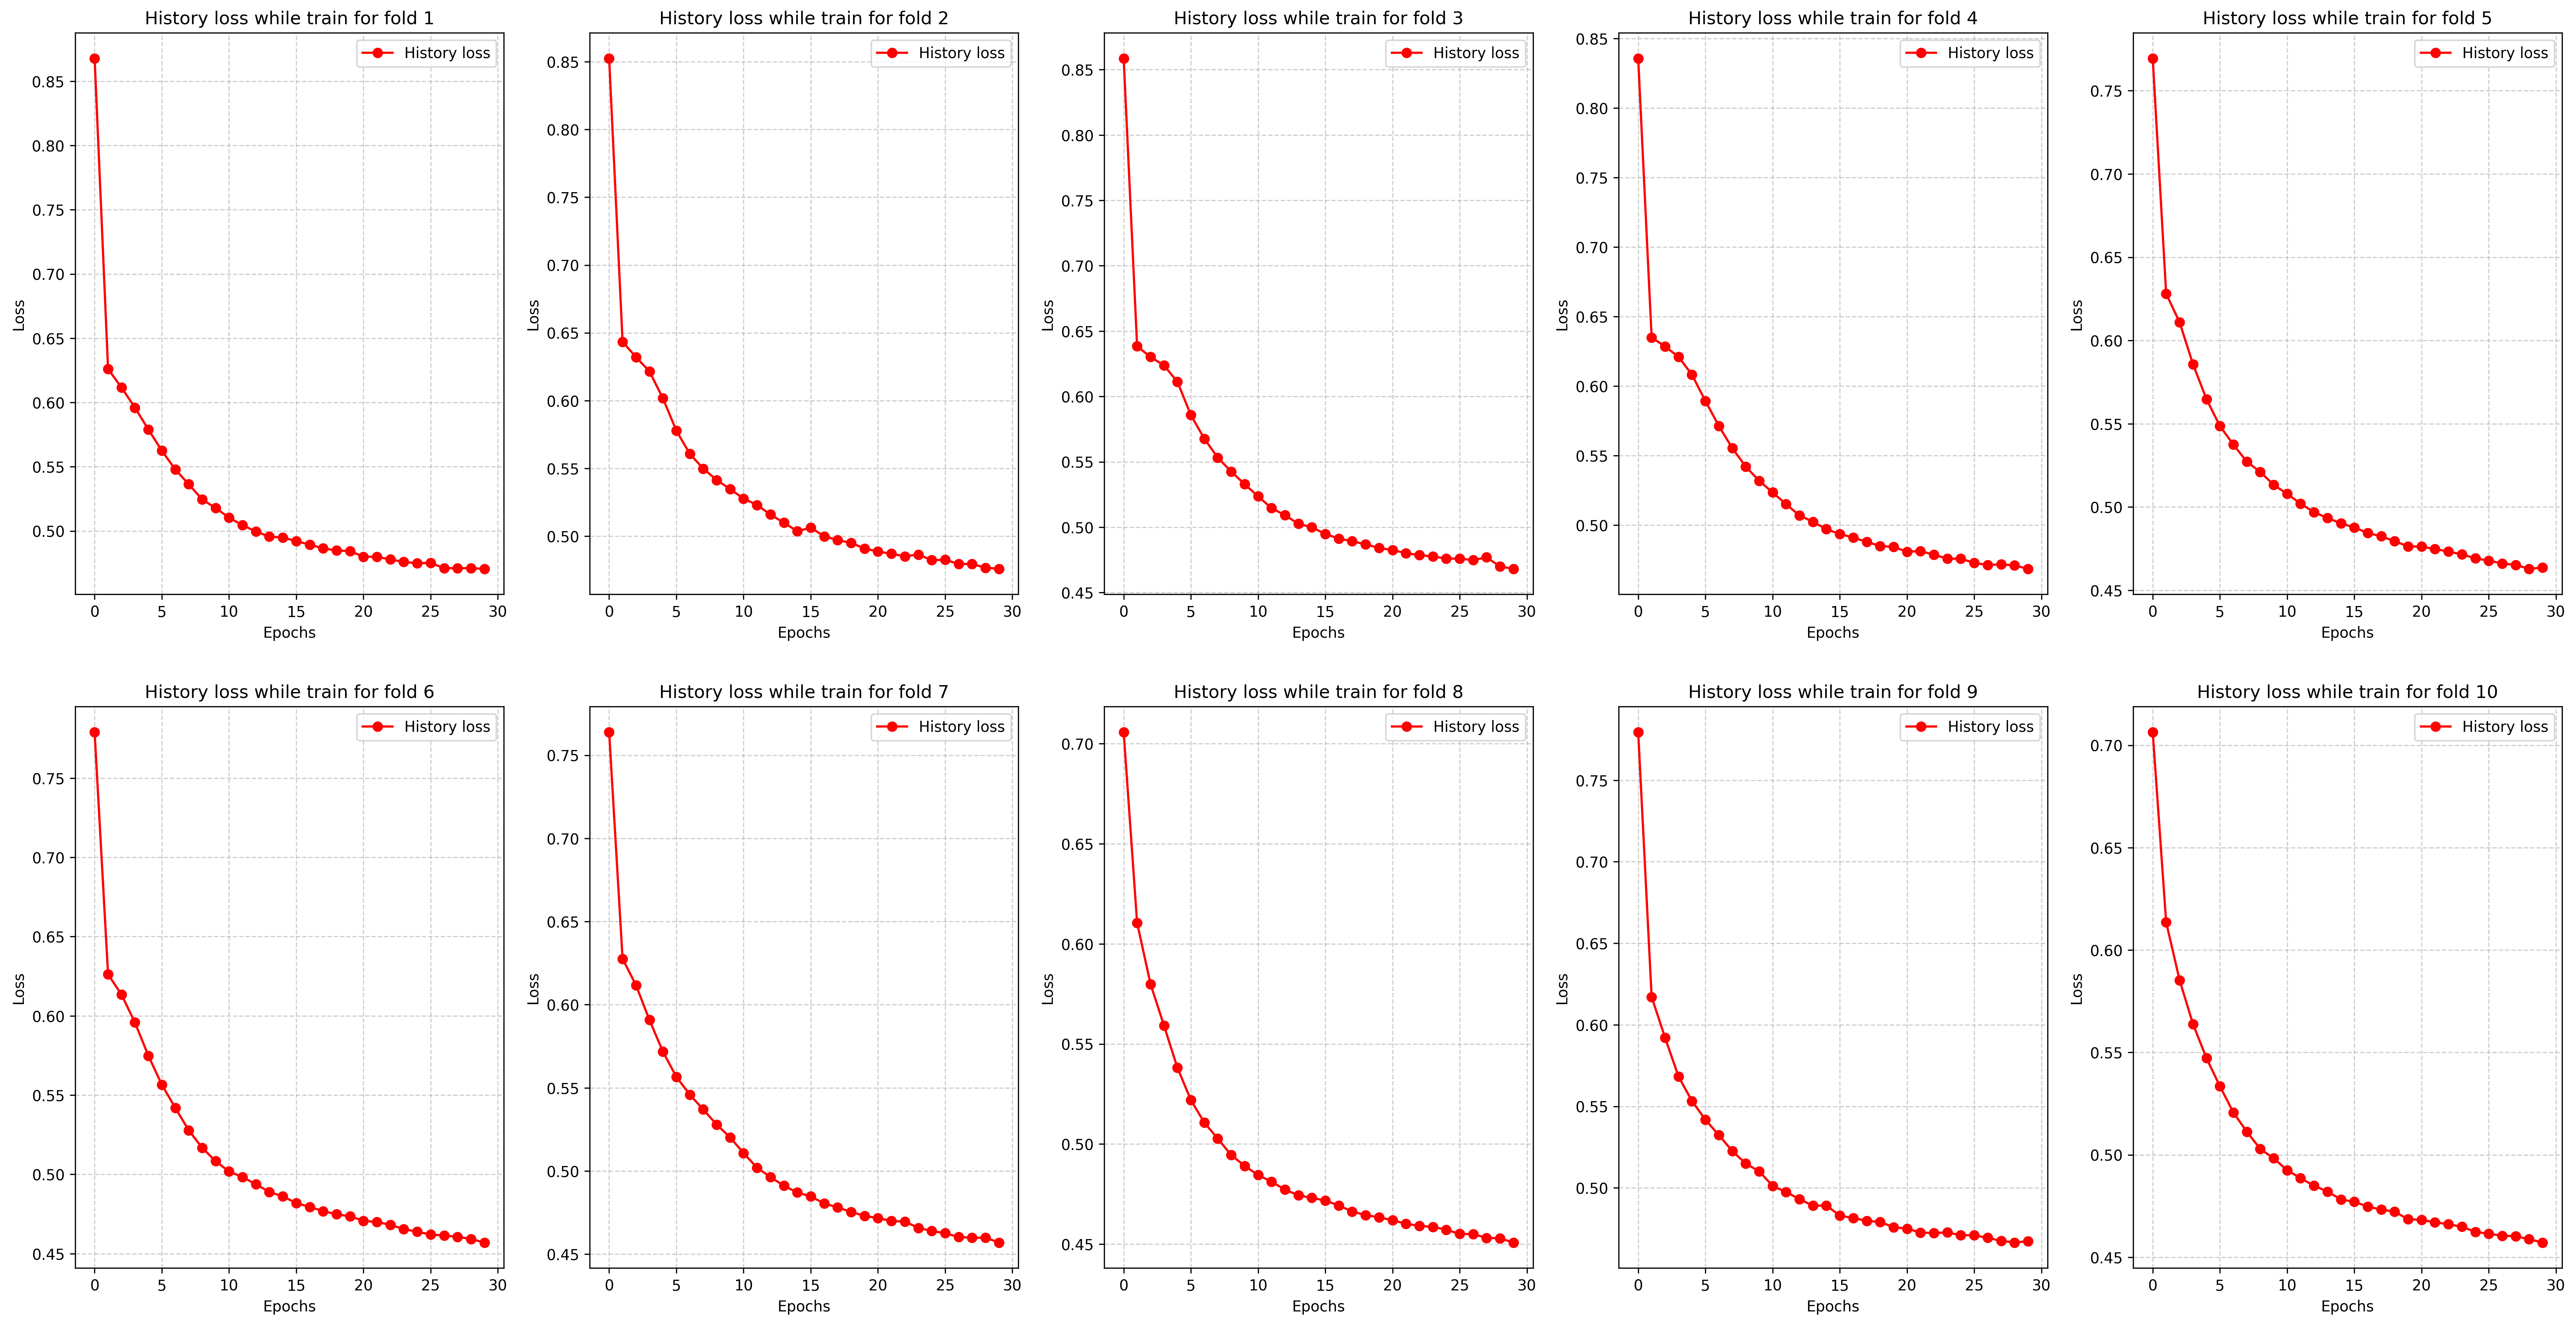

In [37]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Tạo thư mục lưu hình ảnh nếu chưa tồn tại
output_dir = "History loss while train"
os.makedirs(output_dir, exist_ok=True)

# Thiết lập lưới với 2 hàng và 5 cột
rows, cols = 2, 5

# Tạo figure và GridSpec với tỷ lệ ô điều chỉnh
fig = plt.figure(figsize=(30, 15), dpi=300)  # Kích thước tổng thể lớn để chứa 10 biểu đồ
grid = GridSpec(rows, cols, figure=fig, wspace=0.2, hspace=0.2)  # Tăng khoảng cách giữa các ô

# Vẽ từng biểu đồ loss vào các ô trong GridSpec
for i in range(10):  # Tổng cộng 10 folds
    ax = fig.add_subplot(grid[i])  # Gắn đồ thị vào lưới tại vị trí i
    ax.plot(foldloss1[i], label='History loss', color='r', marker='o')
    ax.set_xlabel('Epochs', fontsize=10)
    ax.set_ylabel('Loss', fontsize=10)
    ax.set_title(f'History loss while train for fold {i+1}', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=10)

# Điều chỉnh khoảng cách và lưu figure tổng hợp
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "combined_loss_curves.png"), dpi=300)
plt.show()


In [39]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Tạo thư mục lưu hình ảnh nếu chưa tồn tại
output_dir = "AUC_ROC"
os.makedirs(output_dir, exist_ok=True)

# Thiết lập lưới với 2 hàng và 5 cột
rows, cols = 2, 5

# Tạo figure và GridSpec với tỷ lệ ô điều chỉnh
fig = plt.figure(figsize=(30, 15), dpi=800)  # Kích thước tổng thể lớn để chứa 10 biểu đồ
grid = GridSpec(rows, cols, figure=fig, wspace=0.2, hspace=0.2)  # Tăng khoảng cách giữa các ô

# Vẽ từng biểu đồ AUC_ROC vào các ô trong GridSpec
for i in range(10):  # Tổng cộng 10 folds
    ax = fig.add_subplot(grid[i])  # Gắn đồ thị vào lưới tại vị trí i
    ax.plot(foldvalroc1[i], label=f'AUC_ROC', color='r', marker='o')
    ax.set_xlabel('Epochs', fontsize=10)
    ax.set_ylabel('AUC', fontsize=10)
    ax.set_title(f'AUC_ROC while train for fold {i}', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=10)

# Điều chỉnh khoảng cách và lưu figure tổng hợp
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "combined_auc_roc_curves.png"), dpi=800)
plt.show()


<ipython-input-39-229ffa7f7b42>:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [40]:
mean_val = np.mean(np.max(foldvalroc1, axis=1))
print(f"Trung bình chỉ số AUC_ROC trên tập valid {mean_val}")

Trung bình chỉ số AUC_ROC trên tập valid 0.8021135909790648


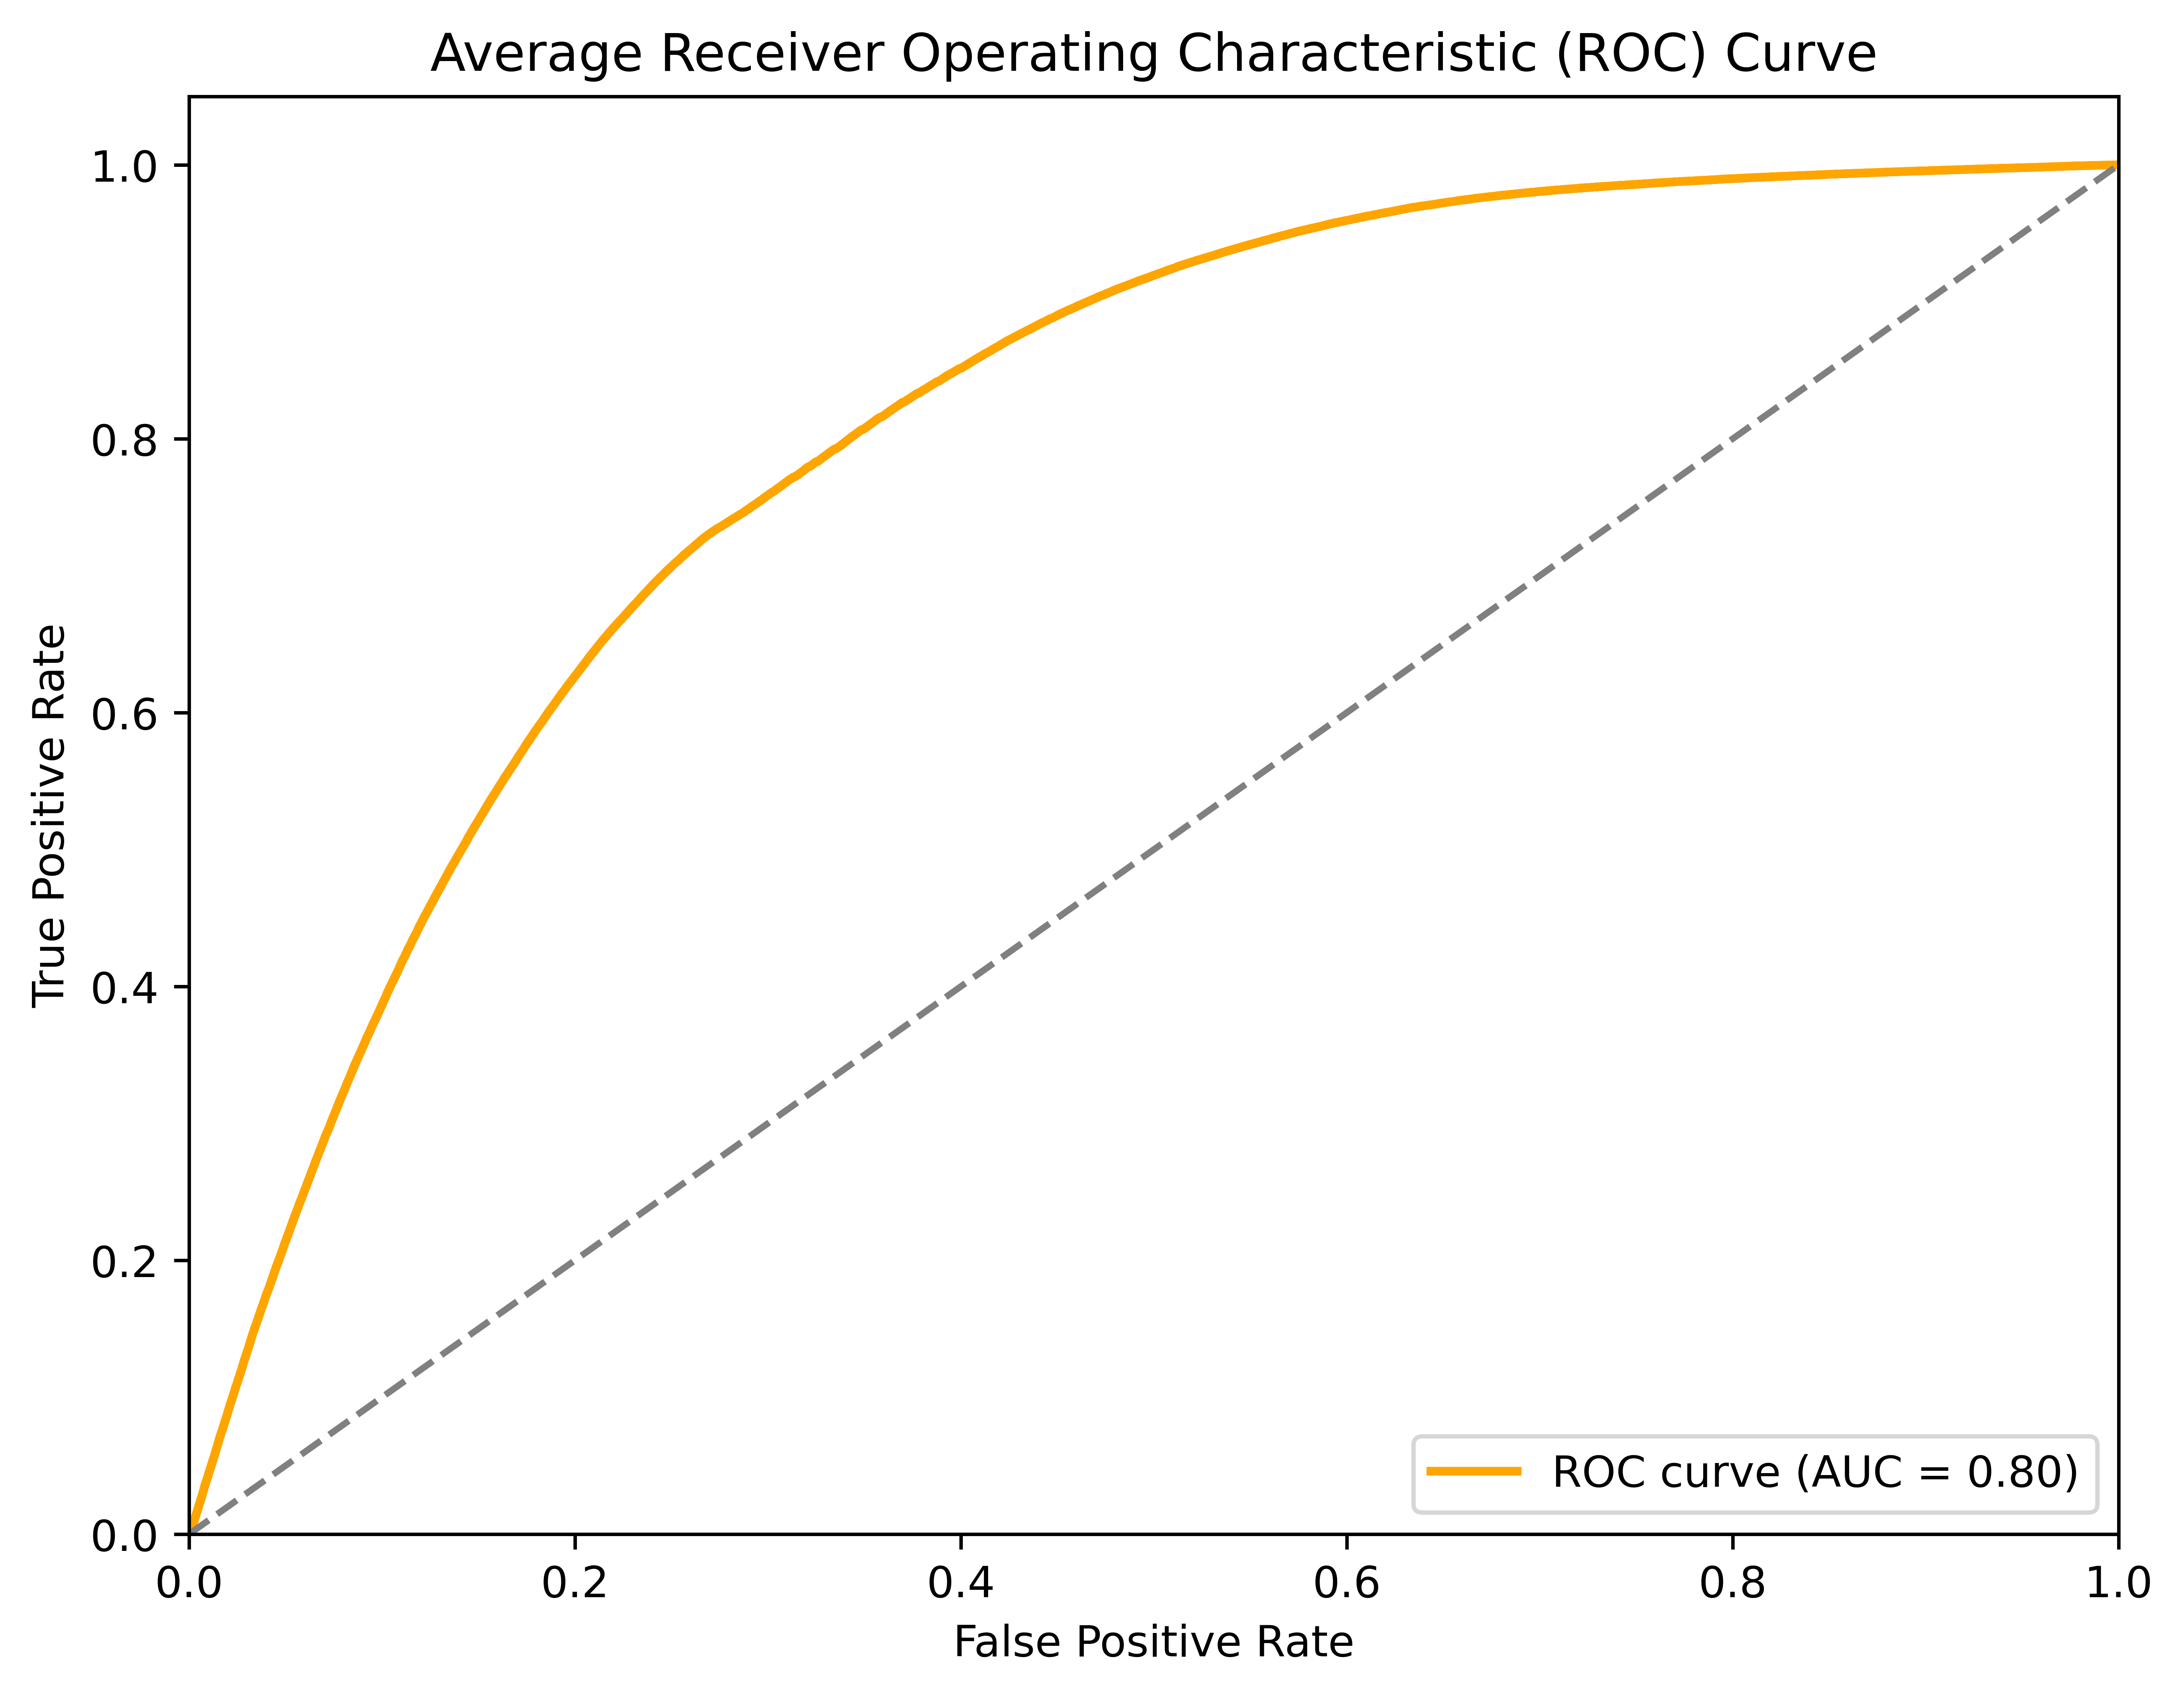

In [54]:
y_true = np.array(truth1).flatten()
y_socre = np.array(predict1).flatten()

fpr, tpr, thresholds = roc_curve(y_true, y_socre)

# Tính AUC
roc_auc = roc_auc_score(y_true, y_socre)
plt.figure(figsize=(8, 6), dpi=800)
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Đường chéo ngẫu nhiên
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"Average Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc='lower right')
plt.savefig("Average Receiver Operating Characteristic (ROC) Curve.png")
plt.show()